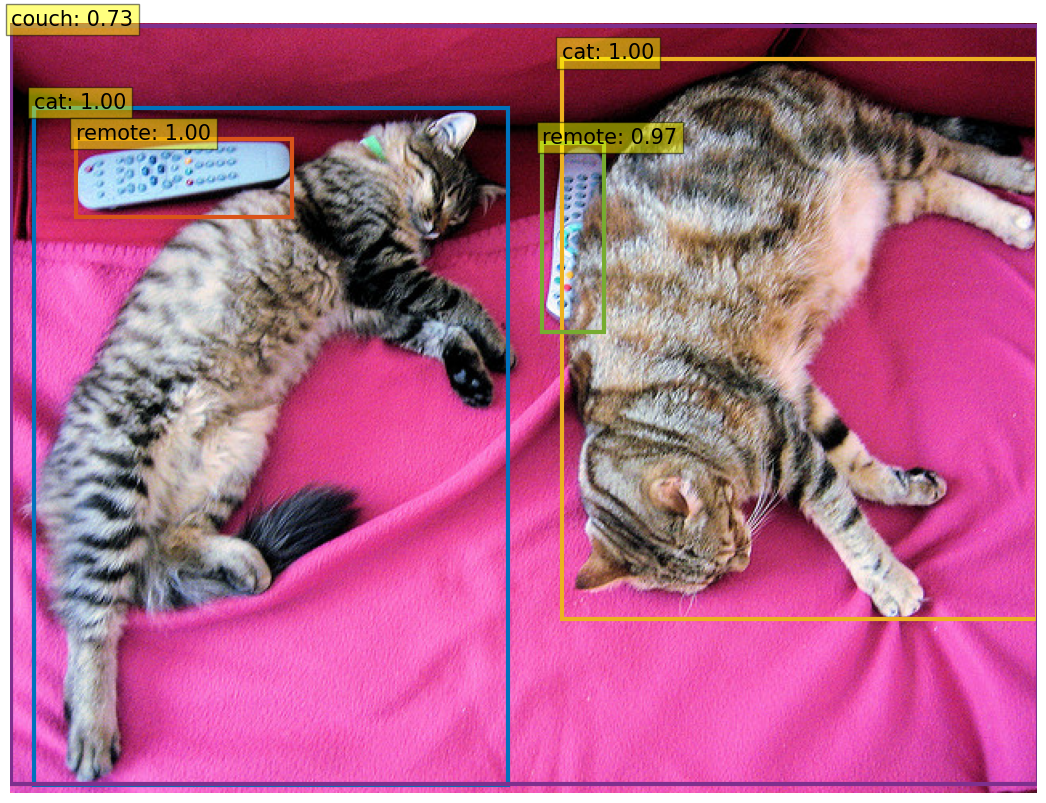

In [4]:
from PIL import Image
import requests
import matplotlib.pyplot as plt 
# %config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

# 定义DETR的最小实现类
class DETRDemo(nn.Module):
    """
        利用最少的代码来实现DETR，相较于原始文献中的DETR，此处实现有3点不同。
         - 可学习的位置编码（取代sine）
         - 位置编码在输入时传递（取代注意力）
         - 全连接层定义的边界框预测器（取代MLP）
    """
    def __init__(self,num_classes,hidden_dim=256,nheads=8,num_encoder_layers=6,num_decoder_layers=6):
        super().__init__()
        # 创建ResNet-50的骨干网
        self.backbone = resnet50()
        # 清除ResNet-50骨干网最后的全连接层
        del self.backbone.fc
        # 创建转换层   1x1的卷积，主要起到改变通道大小的作用
        self.conv = nn.Conv2d(2048,hidden_dim,1)
        # 利用PyTorch内嵌的类，创建Transformer实例
        self.transformer = nn.Transformer(hidden_dim,nheads,num_encoder_layers,num_decoder_layers)
        # 预测头，多出的类别是用于预测non-empty slots
        self.linear_class = nn.Linear(hidden_dim,num_classes+1)
        self.linear_bbox = nn.Linear(hidden_dim,4)
        #  输出位置编码(object queries)
        self.query_pos = nn.Parameter(torch.rand(100,hidden_dim))
        # 空间位置编码
        # ？
        self.row_embed = nn.Parameter(torch.rand(50,hidden_dim//2))
        self.col_embed = nn.Parameter(torch.rand(50,hidden_dim//2))

    def forward(self,inputs):
        # 利用ResNet-50网络前向传播输入到平均池化
        x = self.backbone.conv1(inputs)         # (1,3,800,1066)->(1,64,400,533)
        x = self.backbone.bn1(x)                # (1,64,400,533)->(1,64,400,533)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)            # (1,64,400,533)->(1,64,200,267)
        x = self.backbone.layer1(x)             #
        x = self.backbone.layer2(x)             #
        x = self.backbone.layer3(x)             #
        x = self.backbone.layer4(x)             # (1,2048,25,34)

        # 从2048维度转换到Transformer接受的256维特征平面
        h = self.conv(x)                        # (1,2048,25,34)->(1,hidden_dim,25,34)
        #  构建位置编码
        H,W = h.shape[-2:]                      #
        # (batch_size,34,128)-->(25,34,128)
        # (25,batch_size,128)-->(25,34,128)
        # (25,34,256)-->(25*34,256)-->(25*34,batch_size,256)
        pos = torch.cat([self.col_embed[:W].unsqueeze(0).repeat(H,1,1),
                        self.row_embed[:H].unsqueeze(1).repeat(1,W,1),],dim=-1).flatten(0,1).unsqueeze(1)
        # 继续前向传播通过Transformer
        # 参数1：(25*36,batch_size,256),参数2：(100,batch_size,hidden_dim)
        # 输出：(hidden_dim,100)-->(100,hidden_dim)
        h = self.transformer(pos+0.1*h.flatten(2).permute(2,0,1),self.query_pos.unsqueeze(1)).transpose(0,1)
        # 将Transformer的输出投影到分类标签及边界框
        return {'pred_logits':self.linear_class(h),'pred_boxes':self.linear_bbox(h).sigmoid()}

# COCO类别索引到名称的映射表
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
# 可视化时的边框颜色
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# 标准的ImageNet归一化操作
transform = T.Compose([T.Resize(800),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# 用于边框可视化的函数
# 坐标空间转换
def box_cxcywh_to_xyxy(x):
    x_c,y_c,w,h = x.unbind(1)  #？
    b = [(x_c-0.5*w),(y_c-0.5*h),(x_c+0.5*w),(y_c+0.5*h)]
    return torch.stack(b,dim=1) # ?

# 坐标根据图像尺寸缩放
def rescale_bboxes(out_bbox,size):
    img_w,img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b*torch.tensor([img_w,img_h,img_w,img_h],dtype=torch.float32)
    return b

# 检测函数，整合上述所有功能
def detect(im,model,transform):
    # 对图像归一化，并加入批量维(1)
    # 图像尺寸 (640,480)->(1,3,800,1066)
    img = transform(im).unsqueeze(0)
    # 判断输入图像的长、宽是否符合网络要求，
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600 , '网络支持的输入图像单边最大像素值不可超过1600！'
    # 将图像输入模型进行前向处理
    outputs = model(img)

    # 只保留置信值大于0.7的预测结果
    probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
    keep = probas.max(-1).values >0.7

    # 缩放预测框[0,1]到图像尺寸大小
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0,keep], im.size)
    return probas[keep],bboxes_scaled

# 可视化预测结果
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


# 初始化一个模型
detr = DETRDemo(num_classes=91)
# 下载预训练好的模型参数并导入
# state_dict = torch.hub.load_state_dict_from_url(
#                                 url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
#                                 map_location='cpu',check_hash=True)
pretrained_weights_path = '/root/yunzhi/retrieval/detr_demo-da2a99e9.pth'
# 加载预训练权重
pretrained_weights = torch.load(pretrained_weights_path)
detr.load_state_dict(pretrained_weights)
# detr.load_state_dict(state_dict)
detr.eval()
# 将url指定的图像输入预定义的网络进行检测并获取结果
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
im = Image.open('/root/yunzhi/retrieval/000000039769.jpeg')
scores, boxes = detect(im, detr, transform)
plot_results(im, scores, boxes)